## 데이터 분석 / 모델링 코드
### 필요 Module Import 진행

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import folium
from pyproj import Proj, transform
import mapclassify as mc
from shapely.geometry import Polygon
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

import warnings
warnings.filterwarnings(action='ignore')

from gurobipy import *
import gurobipy as gp

from geneticalgorithm import geneticalgorithm as ga

## '수요'에 대한 분석 진행
### 충전소를 새로 건설할 때, 해당 충전소가 어느 정도 수요가 있을지 파악하는 것이 가장 중요하다. 그렇기에, 충전소의 수요와 관련이 있을 것이라 예상되는 변수들을 파악하고 분석하여 새로 건설될 충전소의 예상 수요로 사용하고자 한다.

### 충전소 수요와 관련 있을 것이라 생각되는 변수는 다음과 같다.
* 1. 배달 수요 데이터 (음식점 데이터)
* 2. 1인가구 데이터
* 3. 오토바이 등록 대수

In [2]:
# 수요와 관련된 데이터에 대한 분석 진행

# 음식점 Data Import
restaurants = pd.read_csv('restaurants.csv', encoding='cp949')

# 서울시 구별 1인가구 수 Data Import
family_gu = pd.read_csv('family_gu.csv')
family_gu = family_gu.iloc[:,1:]
family_gu = family_gu.reindex(sorted(family_gu.columns), axis=1)

# 서울시 구별 오토바이 등록대수 Data Import
bike_gu = pd.read_csv('bike_gu.csv')
bike_gu = bike_gu.reindex(sorted(bike_gu.columns), axis=1)

### 분석을 진행하기에 앞서, 서울시 전체를 '그리드'화 하는 작업을 진행한다.
* 그리드화란, 서울시를 3 by 3 격자로 나누는 작업을 말한다. 그리드화한 후 그리드의 수요를 파악, 그리드별 충전소 설치 작업을 진행한다 

In [3]:
# X좌표 180000, Y좌표 435000을 (0, 0)으로 정의
# Grid 격자의 크기는 3000×3000으로 정의

x_tm = [180000 + 3000*x for x in range(0, 14)]
y_tm = [435000 + 3000*x for x in range(0, 12)]
x_grid = [x//12 for x in range(0, 168)]
y_grid = [x%12 for x in range(0,168)]
grid = pd.DataFrame([x_grid, y_grid], index=['x_grid', 'y_grid']).transpose()
grid['x_tm_start'] = [x_tm[grid.iloc[x, 0]] for x in range(0,168)]
grid['x_tm_end'] = grid['x_tm_start'] + 3000
grid['y_tm_start'] = [y_tm[grid.iloc[x, 1]] for x in range(0,168)]
grid['y_tm_end'] = grid['y_tm_start'] + 3000

# 서뤃시를 그리드로 나눈 후, 각 그리드 별 음식점 개수를 확인
restaurants_necessary = restaurants[['좌표정보(X)', '좌표정보(Y)']]
restaurants_necessary = restaurants_necessary.dropna()
restaurants_necessary['x_grid'] = (restaurants_necessary['좌표정보(X)'] -180000)//3000
restaurants_necessary['y_grid'] = (restaurants_necessary['좌표정보(Y)'] -435000)//3000
restaurants_necessary['restaurants'] = restaurants_necessary['x_grid']*12 + restaurants_necessary['y_grid']
grid_index = pd.DataFrame(restaurants_necessary['restaurants'].astype(int).value_counts())
grid = pd.merge(grid, grid_index, left_index=True, right_index=True, how='left')
grid = grid.fillna(0)

# 음식점 Data를 담고 있는 'restaurants'의 좌표값은 기존에 사용하던 위경도가 아닌 다른 좌표계(EPSG3097)로 되어있음.
# 그렇기에, 우리가 흔히 아는 좌표계(EPSG4326)로 변환하는 작업 진행
proj_2097 = Proj(init='EPSG:2097')
proj_4326 = Proj(init='EPSG:4326')

start_transform = transform(proj_2097, proj_4326, grid['x_tm_start'], grid['y_tm_start'])
end_transform = transform(proj_2097, proj_4326, grid['x_tm_end'], grid['y_tm_end'])
grid_all = pd.merge(grid, pd.DataFrame(start_transform, index=['lat_start', 'lon_start']).transpose(), left_index=True, right_index=True, how='left')
grid_all = pd.merge(grid_all, pd.DataFrame(end_transform, index=['lat_end', 'lon_end']).transpose(), left_index=True, right_index=True, how='left')

# 그리드 좌표를 담고 있는 리스트 선언
grid_list = [[[grid_all.iloc[x, 7], grid_all.iloc[x, 8]], 
             [grid_all.iloc[x, 7], grid_all.iloc[x, 10]], 
             [grid_all.iloc[x, 9], grid_all.iloc[x, 10]],
             [grid_all.iloc[x, 9], grid_all.iloc[x, 8]],
             [grid_all.iloc[x, 7], grid_all.iloc[x, 8]]] for x in range(0,168)]

polygon = []

for grid in grid_list:
    polygon.append(Polygon(grid))

# 각 그리드의 좌표값과 인덱스, 음식점 수의 정보를 담고 있는 데이터프레임 생성
grid_data = gpd.GeoDataFrame({'geometry':polygon})
grid_data.crs = 'EPSG:4326'
grid_data['index_before'] = grid_data.index
grid_data['restaurants'] = grid_all['restaurants'].astype(int)
grid_data = grid_data[grid_data['restaurants'] != 0].reset_index(drop=True)
grid_data['index'] = grid_data.index
grid_data

,geometry,index_before,restaurants,index
0,"POLYGON ((126.77165 37.52502, 126.77165 37.552...",4,5,0
1,"POLYGON ((126.77156 37.55205, 126.77156 37.579...",5,151,1
2,"POLYGON ((126.77148 37.57908, 126.77148 37.606...",6,2,2
3,"POLYGON ((126.80572 37.47102, 126.80572 37.498...",14,300,3
4,"POLYGON ((126.80565 37.49805, 126.80565 37.525...",15,367,4
...,...,...,...,...
79,"POLYGON ((127.14486 37.47109, 127.14486 37.498...",134,237,79
80,"POLYGON ((127.14491 37.49812, 127.14491 37.525...",135,73,80
81,"POLYGON ((127.14496 37.52515, 127.14496 37.552...",136,231,81
82,"POLYGON ((127.14502 37.55218, 127.14502 37.579...",137,339,82


### 음식점 Data는 각 음식점의 좌표값을 가지고 있었기에 그리드 데이터로 변환히 가능하였음. 허나 1인가구 수, 오토바이 등록대수는 정해진 좌표가 있는 것이 아니라 서울시 구별 데이터만 존재하였기에 구 데이터를 그리드 데이터로 변환하는 과정이 필요함
* 서울시 그리드의 구 별 비율을 구하고, 구한 비율을 통해 구 데이터를 그리드 데이터로 변환하는 작업을 진행한다.

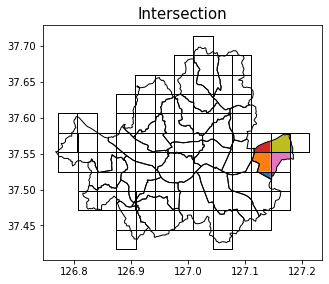

In [4]:
gu_json =  gpd.read_file('gu.json')
gu_json = gu_json[['name', 'geometry']]

# 그리드 안에서 서울시 각 구가 차지하는 비율을 담고 있는 'grid_gu' 데이터프레임 생성 과정
grid_gu = grid_data[['index_before']]
grid3857 = grid_data.to_crs(crs=3857)

for i in range(0, len(gu_json)):
    intersection = gpd.overlay(grid_data, gu_json.iloc[[i]], how='intersection')
    intersection = intersection.to_crs(crs=3857)
    gu_name = gu_json.iloc[i,0]
    intersection[gu_name] = intersection['geometry'].area
    grid_gu = pd.merge(grid_gu, intersection[['index_before', gu_name]], how='left')
    
grid_gu = grid_gu.fillna(0)

inv_area = pd.Series(list(map(lambda x: 1/x, grid3857['geometry'].area)))
grid_gu = grid_gu.iloc[:,1:].multiply(inv_area, axis='index')

# 그리드 내에서 구가 차지하는 비율 구하는 방법 예시
intersection = gpd.overlay(grid_data, gu_json.iloc[[0]], how='intersection')
ax = intersection.plot(figsize=(5,5),cmap='tab10')
grid_data.plot(ax=ax, facecolor='none', edgecolor='k')
gu_json.plot(ax=ax, facecolor='none', edgecolor='k')
plt.title("Intersection", fontsize=15)
plt.show()

### 그리드별 구 비율 데이터를 통해, 구 데이터를 그리드 데이터로 변환하는 작업 진행

In [5]:
# 1인가구 수 그리드 데이터로 변환
family_grid = grid_gu.dot(family_gu.transpose())
family_grid.rename(columns = {0: '1인가구수'}, inplace=True)

# 오토바이 등록대수 그리드 데이터로 변환
bike_grid = grid_gu.dot(bike_gu.transpose())
bike_grid.rename(columns = {0: '오토바이 등록대수'}, inplace=True)

grid_data['1인가구수'] = family_grid['1인가구수']
grid_data['오토바이 등록대수'] = bike_grid['오토바이 등록대수']

In [62]:
bike_grid.to_excel('오토바이 등록대수_그리드.xlsx', index=False)

### 서울시 그리드별 데이터 Plotting 진행
* 지도에 음식점 수, 1인가구 수, 오토바이 등록대수에 따른 색깔 변화로 Plotting을 진행하여, 어느 그리드에 데이터가 집중되어 있는지 확인한다.

In [6]:
# 음식점 데이터 수 Plotting 진행

m = folium.Map(location=[37.5642135, 127.0016985], zoom_start=11)

sim_geo = gpd.GeoSeries(grid_data['geometry'], grid_data['index'])
geo_j = sim_geo.to_json()

folium.Choropleth(
    geo_data=geo_j,
    data=grid_data,
    columns=['index', 'restaurants'],
    key_on='id',
    fill_color='YlGnBu'
).add_to(m)



for _, r in grid_data.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo_new = gpd.GeoSeries(r['geometry'])
    geo_j_new = sim_geo_new.to_json()
    geo_j_new = folium.GeoJson(data=geo_j_new, style_function=lambda x:{'fillColor': '#FF000000', 'color': '#FF000000'})
    folium.Popup(str(r['restaurants'])).add_to(geo_j_new)
    geo_j_new.add_to(m)

m

In [7]:
# 1인가구 데이터 수 Plotting 진행

m = folium.Map(location=[37.5642135, 127.0016985], zoom_start=11)

sim_geo = gpd.GeoSeries(grid_data['geometry'], grid_data['index'])
geo_j = sim_geo.to_json()

folium.Choropleth(
    geo_data=geo_j,
    data=grid_data,
    columns=['index', '1인가구수'],
    key_on='id',
    fill_color='YlGnBu'
).add_to(m)



for _, r in grid_data.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo_new = gpd.GeoSeries(r['geometry'])
    geo_j_new = sim_geo_new.to_json()
    geo_j_new = folium.GeoJson(data=geo_j_new, style_function=lambda x:{'fillColor': '#FF000000', 'color': '#FF000000'})
    folium.Popup(str(r['1인가구수'])).add_to(geo_j_new)
    geo_j_new.add_to(m)

m

In [8]:
# 오토바이 등록대수 데이터 수 Plotting 진행

m = folium.Map(location=[37.5642135, 127.0016985], zoom_start=11)

sim_geo = gpd.GeoSeries(grid_data['geometry'], grid_data['index'])
geo_j = sim_geo.to_json()

folium.Choropleth(
    geo_data=geo_j,
    data=grid_data,
    columns=['index', '오토바이 등록대수'],
    key_on='id',
    fill_color='YlGnBu'
).add_to(m)



for _, r in grid_data.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo_new = gpd.GeoSeries(r['geometry'])
    geo_j_new = sim_geo_new.to_json()
    geo_j_new = folium.GeoJson(data=geo_j_new, style_function=lambda x:{'fillColor': '#FF000000', 'color': '#FF000000'})
    folium.Popup(str(r['오토바이 등록대수'])).add_to(geo_j_new)
    geo_j_new.add_to(m)

m

### 기존 주행 데이터를 통한 '수요'에 대한 정의
* 젠트로피에서 제공한 데이터 중 'bikeBatteryAnalysis'에 따르면, 젠트로피 오토바이 고객의 주행 데이터를 습득할 수 있다. 젠트로피 오토바이를 이용해 주행한 데이터는 충전소 수요와 밀접한 관련이 있을 것이기에 해당 데이터를 분석하여 오토바이 탑승 고객의 주행패턴에 대해 분석하고자 한다. 허나, 기존 충전소는 강남에 밀집되어 있기에 주행 데이터 역시 강남에 치우쳐서 나타나게 될 것이다. 그렇기에 해당 데이터를 그대로 사용하여 '수요'라고 정의해버리면 새로 설치되는 충전소 역시 강남에 치우치는 현상이 나타날 것이기에 새로 설치될 충전소의 수요는 해당 데이터가 아닌, 이전에 분석한 '음식점 수', '1인가구 수', '오토바이 등록대수' 등을 사용하고자 한다.
* 오토바이 운전자가 기존 그리드를 벗어나 새로운 그리드에 진입할 경우, 새로 진입한 그리드의 교통량이 1 증가하였다고 판단한다. 위와 같은 과정을 통해, 전체 그리드의 교통량 데이터를 측정하여 교통량 빈도수를 비교해보고자 한다.

In [9]:
# bikeBatteryAnalysis 데이터셋 import
bike_battery_analysis = pd.read_csv('bikeBatteryAnalysis.csv')
bike_battery_analysis = bike_battery_analysis[(bike_battery_analysis['lat']!=0) & (bike_battery_analysis['lon'] != 0)]
bike_battery_analysis = bike_battery_analysis.iloc[:,1:].reset_index(drop=True)

# 분석 편의를 위해 좌표계를 변경하여 분석 진행
bike_battery_analysis_tf = transform(proj_4326, proj_2097, bike_battery_analysis['lon'], bike_battery_analysis['lat'])
bike_battery_analysis_tf = pd.DataFrame(bike_battery_analysis_tf)
bike_battery_analysis_tf = bike_battery_analysis_tf.transpose()
bike_battery_analysis_tf['x_grid'] = (bike_battery_analysis_tf[0] -180000)//3000
bike_battery_analysis_tf['y_grid'] = (bike_battery_analysis_tf[1] -435000)//3000
# 주행 데이터가 서울을 벗어난 곳에 찍혀 있는지 확인
bike_battery_analysis_tf['x_error'] = np.where((bike_battery_analysis_tf['x_grid']>= 0) & (bike_battery_analysis_tf['x_grid'] <= 13), "No", "Yes")
bike_battery_analysis_tf['y_error'] = np.where((bike_battery_analysis_tf['y_grid']>= 0) & (bike_battery_analysis_tf['y_grid'] <= 11), "No", "Yes")
bike_battery_analysis_tf['error'] = np.where((bike_battery_analysis_tf['x_error'] == 'No') & (bike_battery_analysis_tf['y_error'] == 'No'), "No", "Yes")
bike_battery_analysis_tf['grid'] = bike_battery_analysis_tf['x_grid']*12 + bike_battery_analysis_tf['y_grid']

# bikeBatteryAnalysis의 좌표값이 어느 그리드에 해당하는지 확인
bike_battery_analysis['grid'] = bike_battery_analysis_tf['grid']
# 그리드가 서울을 벗어난 데이터들 제거
bike_battery_analysis_filtered = bike_battery_analysis[bike_battery_analysis_tf['error'] == 'No']
bike_battery_analysis_filtered['grid'] = bike_battery_analysis_filtered['grid'].astype(int)

# 오토바이 시리얼번호 저장
serial = bike_battery_analysis_filtered['biSerial'].unique()

# 그리드별 교통량 데이터를 저장하는 데이터프레임
grid_traffic = pd.DataFrame([0], columns={'grid'})

# 오토바이 시리얼 별 주행 데이터 확인
for se in serial:
    df = bike_battery_analysis_filtered[bike_battery_analysis_filtered['biSerial'] == se]
    df['changed'] = df['grid'].diff()
    df['changed'] = df['changed'].fillna(1)
    df_fil = df[df['changed'] != 0]
    grid_traffic = pd.concat([grid_traffic, pd.DataFrame(df_fil['grid'].value_counts())], axis=1).fillna(0).sum(axis=1)

# 교통량 데이터 'traffic' 컬럼에 저장
grid_traffic = pd.DataFrame(grid_traffic, columns={'traffic'})
grid_traffic['index_before'] = grid_traffic.index

# 기존 그리드 데이터 정보를 저장하는 데이터프레임에 교통량 데이터 저장
grid_data = pd.merge(grid_data, grid_traffic, on='index_before', how='left')
grid_data['traffic'] = grid_data['traffic'].fillna(0)

# 교통량 데이터가 강남에 몰려있기에 Plotting하기 어려움. 따라서, 로그스케일링을 진행하여 편차를 작게 하는 과정을 거친다.
grid_data['traffic_scale'] = grid_data['traffic']
grid_data = grid_data.replace({'traffic_scale' : 0}, 0.1)
grid_data['traffic_scale'] = np.log(grid_data['traffic_scale'])

# 음식점 수, 1인가구 수, 오토바이 등록대수, 교통량 등의 정보를 저장하고 있는 데이터프레임
grid_data

,geometry,index_before,restaurants,index,1인가구수,오토바이 등록대수,traffic,traffic_scale
0,"POLYGON ((126.77165 37.52502, 126.77165 37.552...",4,5,0,36723.749742,73410.945284,1.0,0.000000
1,"POLYGON ((126.77156 37.55205, 126.77156 37.579...",5,151,1,63495.277990,126927.353852,1.0,0.000000
2,"POLYGON ((126.77148 37.57908, 126.77148 37.606...",6,2,2,11691.158007,23370.678834,0.0,-2.302585
3,"POLYGON ((126.80572 37.47102, 126.80572 37.498...",14,300,3,27671.530207,67413.746282,25.0,3.218876
4,"POLYGON ((126.80565 37.49805, 126.80565 37.525...",15,367,4,17666.975830,54320.884312,39.0,3.663562
...,...,...,...,...,...,...,...,...
79,"POLYGON ((127.14486 37.47109, 127.14486 37.498...",134,237,79,25590.970066,75701.319402,804.0,6.689599
80,"POLYGON ((127.14491 37.49812, 127.14491 37.525...",135,73,80,6573.407297,18180.394667,583.0,6.368187
81,"POLYGON ((127.14496 37.52515, 127.14496 37.552...",136,231,81,35405.981069,90010.397281,83.0,4.418841
82,"POLYGON ((127.14502 37.55218, 127.14502 37.579...",137,339,82,44640.283458,113486.183056,22.0,3.091042


### 교통량 데이터를 Plotting해보면서 경향성 확인
* 로그스케일링 이전 데이터를 Plotting하면서 데이터가 현재 얼마나 편향되어 있는지 확인하고, 스케일링한 데이터를 Plotting함으로써 그리드별 교통량 데이터의 경향성을 파악하고자 한다.

In [10]:
# 쿄통량 데이터 스케일링 이전 Plotting

m = folium.Map(location=[37.5642135, 127.0016985], zoom_start=11)

sim_geo = gpd.GeoSeries(grid_data['geometry'], grid_data['index'])
geo_j = sim_geo.to_json()

folium.Choropleth(
    geo_data=geo_j,
    data=grid_data,
    columns=['index', 'traffic'],
    key_on='id',
    fill_color='YlGnBu'
).add_to(m)



for _, r in grid_data.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo_new = gpd.GeoSeries(r['geometry'])
    geo_j_new = sim_geo_new.to_json()
    geo_j_new = folium.GeoJson(data=geo_j_new, style_function=lambda x:{'fillColor': '#FF000000', 'color': '#FF000000'})
    folium.Popup(str(r['traffic'])).add_to(geo_j_new)
    geo_j_new.add_to(m)

m

In [11]:
# 쿄통량 데이터 스케일링 이후 Plotting

m = folium.Map(location=[37.5642135, 127.0016985], zoom_start=11)

sim_geo = gpd.GeoSeries(grid_data['geometry'], grid_data['index'])
geo_j = sim_geo.to_json()

folium.Choropleth(
    geo_data=geo_j,
    data=grid_data,
    columns=['index', 'traffic_scale'],
    key_on='id',
    fill_color='YlGnBu'
).add_to(m)



for _, r in grid_data.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo_new = gpd.GeoSeries(r['geometry'])
    geo_j_new = sim_geo_new.to_json()
    geo_j_new = folium.GeoJson(data=geo_j_new, style_function=lambda x:{'fillColor': '#FF000000', 'color': '#FF000000'})
    folium.Popup(str(r['traffic_scale'])).add_to(geo_j_new)
    geo_j_new.add_to(m)

m

### 변수간 Correlation 파악
* 음식점 수, 1인가구 수, 오토바이 등록대수와 교통량 데이터의 Correlation을 파악하여, 기존 교통량 데이터와 Correlation이 가장 큰 변수를 찾아낸다.
* 찾아낸 변수를 이용하여 새로 설치될 충전소의 잠재적 수요를 예측하고 이를 통해 모델링을 진행하고자 한다.

In [12]:
# Correlation 파악
grid_data[['restaurants', '1인가구수', '오토바이 등록대수', 'traffic', 'traffic_scale']].corr()

,restaurants,1인가구수,오토바이 등록대수,traffic,traffic_scale
restaurants,1.000000,0.319425,0.342353,0.403873,0.426652
1인가구수,0.319425,1.000000,0.697874,0.193764,0.458954
오토바이 등록대수,0.342353,0.697874,1.000000,0.513359,0.607830
traffic,0.403873,0.193764,0.513359,1.000000,0.506729
traffic_scale,0.426652,0.458954,0.607830,0.506729,1.000000


### 교통량 데이터와 스케일링한 교통량 데이터 모두 '오토바이 등록대수' 변수와 상관관계가 높게 나왔다. 그렇기에, 잠재적인 충전소 수요를 '오토바이 등록대수' 데이터를 사용하여 예측해보고자 한다.

### 모델링 준비
* 모델링에 사용할 변수들을 선언하는 과정을 진행한다.

In [13]:
# 이웃노드 정의
# i 노드를 기준으로 이웃노드이거나 본인노드일 경우 1, 아닐 경우 0으로 나타낸 데이터프레임 호출
neighbor_node = pd.read_excel('neighbor_node.xlsx')
neighbor_node = neighbor_node.iloc[:,1:].fillna(0)

# Neighbor node 정보를 이용하여 기점노드에서 종점노드로 가는 모든 경우의 수 리스트로 저장
move_list = [(i,j) for i in range(84) for j in range(84) if neighbor_node.iloc[i,j]==1]

# 충전소 후보지 데이터 호출
candidate_site = pd.read_excel('convenienceStore.xlsx')

# 충전소 후보지의 좌표값을 통해 어느 그리드에 해당하는지 확인
proj_2097 = Proj(init='EPSG:2097')
proj_4326 = Proj(init='EPSG:4326')

candidate_site_latlon = transform(proj_4326, proj_2097, candidate_site['경도'], candidate_site['위도'])
candidate_site_latlon = pd.DataFrame(sorted([candidate_site_latlon[0].tolist(), candidate_site_latlon[1].tolist()]), 
                                     index=('경도', '위도')).transpose()
# 위도, 경도에 따른 그리드 확인 후 후보지 위경도가 서울을 벗어나는지 여부 확인
candidate_site_latlon['x_grid'] = (candidate_site_latlon['경도'] -180000)//3000
candidate_site_latlon['y_grid'] = (candidate_site_latlon['위도'] -435000)//3000
candidate_site_latlon['x_error'] = np.where((candidate_site_latlon['x_grid']>= 0) 
                                            & (candidate_site_latlon['x_grid'] <= 13), "No", "Yes")
candidate_site_latlon['y_error'] = np.where((candidate_site_latlon['y_grid']>= 0) 
                                            & (candidate_site_latlon['y_grid'] <= 11), "No", "Yes")
candidate_site_latlon['error'] = np.where((candidate_site_latlon['x_error'] == 'No') 
                                          & (candidate_site_latlon['y_error'] == 'No'), "No", "Yes")
candidate_site_latlon['grid'] = candidate_site_latlon['x_grid']*12 + candidate_site_latlon['y_grid']

# 그리드 인덱스 값 저장
candidate_site['index_before'] = candidate_site_latlon['grid']

# 위경도가 서울시를 벗어나는 경우 필터링
candidate_site_filtered = candidate_site[candidate_site_latlon['error'] == 'No']
candidate_site_filtered['index_before'] = candidate_site_filtered['index_before'].astype(int)

# 서울시를 벗어나는 경우 필터링한 후 충전소 후보지 별 그리드 위치 저장
grid = grid_data[['index_before', 'index']]
candidate_site_filtered = pd.merge(candidate_site_filtered, grid, on='index_before', how='left')
candidate_site_filtered = candidate_site_filtered.dropna()

# 그리드 인덱스를 저장하는 데이터프레임 생성
candidate_site_index = candidate_site_filtered[['상호명', 'index']].reset_index(drop=True)
candidate_site_index['index'] = candidate_site_index['index'].astype(int)

# 기점노드에서 종점노드로 이동할 때, 모든 충전소 후보지를 방문하는 경로를 담고 있는 리스트 생성
candidate_site_list = [1 if ((neighbor_node[i][candidate_site_index['index'][k]]==1.0)
                             |(neighbor_node[j][candidate_site_index['index'][k]]==1.0)) 
                       else 0 for i,j in move_list for k in range(930)]

# 충전소 후보지는 이웃노드로만 갈 수 있기에, 모든 충전소 후보지를 방문하는 경우에서 이웃노드 방문하는 경우만 추려냄
charger_visit_list = [(i,j,k) for i,j in move_list for k in range(930) 
                      if candidate_site_list[930*move_list.index((i,j))+k] == 1]
charger_visit_df = pd.DataFrame(charger_visit_list)

# '수요'로 사용하기 위한 '오토바이 등록대수' 데이터 정의
motorcycle = grid_data['오토바이 등록대수']
# '오토바이 등록대수'를 통해 사용하고자 하는 '교통량(수요)' 리스트
traffic_list = [(motorcycle[i]+motorcycle[j])/2 for i,j in move_list]

## 모델링 진행
### 서울시 그리드 데이터를 이용하여, 충전소의 부하를 밸런싱하는 모델링을 진행하고자 한다. 충전소에 가해지는 부하의 최대치를 Minimize 하는 혼합정수계획법을 진행하여 충전소의 부하를 밸런싱한다.
* 모든 그리드(84개)를 기점노드(출발지)로 하며, 기점 노드에서 (이웃노드/본인노드)로 이동하는 모든 경우의 수를 확인한다. 이 때 이동하는 노드를 종점노드(도착지)라고 한다.
* 기점노드에서 종점노드로 이동할 때, 반드시 한 군데의 충전소에 방문하여 배터리 교환을 진행한다. 이 때, 방문 가능한 노드는 기점노드와 종점노드의 이웃노드로 한다. (이웃노드란, 기준이 되는 노드 기준 가로 세로 대각선 한 칸 이내의 노드를 말한다.)
* 기점노드에서 종점노드로 이동할 때 방문한 충전소의 수요는 기점노드와 종점노드 수요의 평균 값을 사용한다. 즉, 데이터 분석을 통해 사용하기로 결정된 '오토바이 등록대수'의 '기점노드&종점노드 평균 값을 해당 충전소의 수요'라고 정의하는 것이다.
* 각 충전소의 총 수요는 해당 충전소에 방문하는 모든 경로의 수요 합을 의미한다.
* 충전소 수요의 Maximum값을 Minimize하는 모델을 작성한다.

### Gurobi MIP 코드 설명
#### 변수 설명
* x: 충전소 후보지에 충전소를 설치할 지 결정하는 변수, (0: 설치하지 않음, 1: 설치함)
* y: i노드에서 j노드로 갈 때, 충전소 후보지 k를 방문할 지 결정하는 변수, 이 때 충전소 후보지 k에 충전소가 설치되어 있어야만 방문할 수 있다. (0: 방문하지 않음, 1: 방문함)
* L: 충전소별 부하의 최대치, 해당 값을 Minimize함으로써 각 충전소의 부하를 밸런싱하는 과정을 진행함

#### 목적식 설명
* Minimize L -> 충전소 최대 부하를 최소화함으로써 각 충전소의 부하를 밸런싱한다.

#### 제약식 설명
* i노드에서 j노드로 갈 때, 반드시 하나의 충전소를 방문한다.
* 충전소 후보지 k에 충전소가 건설이 안 된다면, 해당 충전소를 방문할 수 없다.
* 충전소 부하 최대값인 L은 k 충전소의 부하보다 크다.
* 충전소 후보지 k에 건설되는 충전소의 총합은 100개이다. (유동적 변경 가능)

In [19]:
m = Model('LoadBalancing')
# m.ModelSense = GRB.MINIMIZE

# Guribi의 Time Limit 설정
m.setParam('TimeLimit', 60*60*2)

# 충전소 후보지 충전소 건설 여부
x = m.addVars(len(candidate_site_index), vtype=GRB.BINARY, name="x")
# i노드에서 j노드로 이동할 때 k충전소 방문하는지 여부
y = m.addVars(charger_visit_list, vtype=GRB.BINARY, name="y")
# 충전소 부하 최대치
L = m.addVar(vtype=GRB.CONTINUOUS, name="L_max")

# 충전소 최대 부하값을 최소화
m.setObjective(L, GRB.MINIMIZE)

# i노드에서 j노드로 이동할 때 반드시 하나의 충전소를 방문
m.addConstrs((y.sum(i,j,'*') == 1 for i,j in move_list), 'must_charger_visit')
# 충전소 후보지 k에 충전소가 설치되어 있지 않으면 방문하지 않음
m.addConstrs((y[i,j,k] <= x[k] for i,j,k in charger_visit_list), 'no_charger_no_visit')
# 충전소 후보지 k의 부하 총합보다 L이 커야 함
for k in range(len(candidate_site_index)):
    m.addConstr((gp.quicksum(traffic_list[move_list.index((i,j))]*y[i,j,k] 
                             for i,j in charger_visit_df[charger_visit_df[2] == k].iloc[:,:-1].values.tolist())) <= L )
# m.addConstrs((y.sum('*','*',k) <= L for k in range(len(conv_index))), 'L_max meaning')
# m.addConstrs((x.sum(k) <= 100 for k in range(len(conv_index))), 'charger_limit')
# 충전소의 총합은 n개를 넘어가지 않음
m.addConstr((gp.quicksum(x[k] for k in range(len(candidate_site_index))) <= 100), 'charger_limit')

m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter TimeLimit to value 7200
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 87115 rows, 86484 columns and 344072 nonzeros
Model fingerprint: 0x37303ff1
Variable types: 1 continuous, 86483 integer (86483 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve time: 1.51s
Presolved: 87115 rows, 86484 columns, 344072 nonzeros
Variable types: 1 continuous, 86483 integer (86483 binary)
Found heuristic solution: objective 1.385490e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Use cr

### 지금까지의 최적화는 기존 충전소를 반영하지 않고 충전소 설치를 진행하였으며, 이는 데이터 수집이 지연되었기 때문이다. 허나 기존 충전소를 고려하지 않고 로드밸런싱을 진행할 시 '기존 충전소를 설치하지 않아야 한다'라는 결론이 나올 수 있으므로, 기존 충전소 위치를 직접 수집한 후 MIP를 다시 진행한다.

In [14]:
# 기존 충전소 위치 Import
zentropy = pd.read_excel('zentropy.xlsx')
zentropy['상호명'] = zentropy['Name']

# 기존 충전소의 좌표값을 통해 어느 그리드에 해당하는지 확인
proj_2097 = Proj(init='EPSG:2097')
proj_4326 = Proj(init='EPSG:4326')

zentropy_latlon = transform(proj_4326, proj_2097, zentropy['경도'], zentropy['위도'])
zentropy_latlon = pd.DataFrame(sorted([zentropy_latlon[0].tolist(), zentropy_latlon[1].tolist()]), 
                                     index=('경도', '위도')).transpose()
# 위도, 경도에 따른 그리드 확인
zentropy_latlon['x_grid'] = (zentropy_latlon['경도'] -180000)//3000
zentropy_latlon['y_grid'] = (zentropy_latlon['위도'] -435000)//3000
zentropy_latlon['grid'] = zentropy_latlon['x_grid']*12 + zentropy_latlon['y_grid']

# 그리드 인덱스 값 저장
zentropy['index_before'] = zentropy_latlon['grid']
zentropy_grid = pd.merge(zentropy, grid, on='index_before', how='left')
zentropy_index = zentropy_grid[['상호명', 'index']]

zentropy_index['index'] = zentropy_index['index'].astype(int)

# 충전소 후보지와 기존 충전소 데이터 결합
charging_station_index = pd.concat([candidate_site_index, zentropy_index]).reset_index(drop=True)

charging_station_length = len(charging_station_index)

# 기점노드에서 종점노드로 이동할 때, 모든 충전소를 방문하는 경로를 담고 있는 리스트 생성
charging_station_list = [1 if ((neighbor_node[i][charging_station_index['index'][k]]==1.0)
                             |(neighbor_node[j][charging_station_index['index'][k]]==1.0)) 
                         else 0 for i,j in move_list for k in range(charging_station_length)]

# 충전소는 이웃노드로만 갈 수 있기에, 모든 충전소를 방문하는 경우에서 이웃노드 방문하는 경우만 추려냄
charger_visit_list_all = [(i,j,k) for i,j in move_list for k in range(charging_station_length) 
                      if charging_station_list[charging_station_length*move_list.index((i,j))+k] == 1]
charger_visit_df_all = pd.DataFrame(charger_visit_list_all)

# '수요'로 사용하기 위한 '오토바이 등록대수' 데이터 정의
motorcycle = grid_data['오토바이 등록대수']
# '오토바이 등록대수'를 통해 사용하고자 하는 '교통량(수요)' 리스트
traffic_list = [(motorcycle[i]+motorcycle[j])/2 for i,j in move_list]

In [39]:
m = Model('LoadBalancing_All')
# m.ModelSense = GRB.MINIMIZE

# Guribi의 Time Limit 설정
m.setParam('TimeLimit', 60*60*2)

# 충전소 후보지 충전소 건설 여부
x = m.addVars(len(charging_station_index), vtype=GRB.BINARY, name="x")
# i노드에서 j노드로 이동할 때 k충전소 방문하는지 여부
y = m.addVars(charger_visit_list_all, vtype=GRB.BINARY, name="y")
# 충전소 부하 최대치
L = m.addVar(vtype=GRB.CONTINUOUS, name="L_max")



# 충전소 최대 부하값을 최소화
m.setObjective(L, GRB.MINIMIZE)

# i노드에서 j노드로 이동할 때 반드시 하나의 충전소를 방문
m.addConstrs((y.sum(i,j,'*') == 1 for i,j in move_list), 'must_charger_visit')
# 충전소 후보지 k에 충전소가 설치되어 있지 않으면 방문하지 않음
m.addConstrs((y[i,j,k] <= x[k] for i,j,k in charger_visit_list_all), 'no_charger_no_visit')
# 충전소 후보지 k의 부하 총합보다 L이 커야 함
for k in range(len(charging_station_index)):
    m.addConstr((gp.quicksum(traffic_list[move_list.index((i,j))]*y[i,j,k] 
                             for i,j in charger_visit_df_all[charger_visit_df_all[2] == k].iloc[:,:-1].values.tolist())) <= L )
# m.addConstrs((y.sum('*','*',k) <= L for k in range(len(conv_index))), 'L_max meaning')
# m.addConstrs((x.sum(k) <= 100 for k in range(len(conv_index))), 'charger_limit')
# 충전소의 총합은 n개를 넘어가지 않음
m.addConstr((gp.quicksum(x[k] for k in range(len(charging_station_index))) <= 150), 'charger_limit')
# 기존에 설치되어 있는 충전소는 반드시 설치되어야 됨
m.addConstrs((x[k] == 1 for k in range(len(candidate_site_index), len(charging_station_index))), 'existing_charger')

m.optimize()

Set parameter TimeLimit to value 300
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 98185 rows, 97444 columns and 387802 nonzeros
Model fingerprint: 0xf4381e5e
Variable types: 1 continuous, 97443 integer (97443 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 10960 rows and 110 columns
Presolve time: 1.07s
Presolved: 87225 rows, 97334 columns, 365882 nonzeros
Variable types: 1 continuous, 97333 integer (97333 binary)
Found heuristic solution: objective 1.385490e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.02s

Solved with primal simplex

Use crossover to convert LP symmetric solution to ba

### MIP 모델링을 통해, 그리드 간 충전소 개수에 대한 파악은 가능하다. 허나, 그리드 내 충전소 배치는 MIP를 통해 구할 수 없다. 그렇기에, 그리드 내 충전소를 배치하기 위해 다음과 같은 알고리즘을 사용한 후, 결과를 비교한다.

* 경쟁사의 충전소 거리를 비교하여, 경쟁사 충전소와 가장 먼 곳에 위치한 후보지에 충전소를 설치한다. 이 때, 새로 설치되는 충전소 간 거리는 고려하지 않는다.
* 경쟁사의 충전소 거리를 비교하여 그리드 내 첫 충전소를 설치한다. 이후, 다음으로 설치되는 충전소는 직전에 설치한 충전소와 가장 거리가 먼 후보지에 설치한다.

In [58]:
x_150 = pd.read_excel('sample150x_24h.xlsx')

dna_motors = pd.read_csv('dna_motors.csv', encoding='euc_kr')

dist=[]
for i in candidate_site_filtered.index:
    minimum = 100
    for j in dna_motors.index:
        if (abs(candidate_site_filtered['위도'][i]-dna_motors['위도'][j])+
            abs(candidate_site_filtered['경도'][i]-dna_motors['경도'][j])) < minimum:
            minimum = (abs(candidate_site_filtered['위도'][i]-dna_motors['위도'][j])+
                       abs(candidate_site_filtered['경도'][i]-dna_motors['경도'][j]))
    dist.append(minimum)
candidate_site_filtered['minimum_dist'] = dist

candidate_site_grid = candidate_site_filtered[['상호명', 'index']].reset_index(drop=True)
candidate_site_grid['index'] = candidate_site_grid['index'].astype(int)

candidate_site_150 = candidate_site_index
candidate_site_150['construct'] = x_150
candidate_site_150[candidate_site_150['construct'] == 1]

grid_data['station'] = 0

candidate_site_construct = candidate_site_150[candidate_site_150['construct'] == 1].reset_index(drop=True)

for i in range(len(candidate_site_construct)):
    grid_data['station'][candidate_site_construct['index'][i]] += 1

# 후보지 별 그리드 내 Rank 확인 -> Rank가 높은 순서대로 설치
candidate_site_1st = candidate_site_filtered
candidate_site_1st['rank'] = candidate_site_1st.groupby('index')['minimum_dist'].rank(method='min', ascending=False)
candidate_site_1st = candidate_site_1st.sort_values(by=['index', 'rank']).reset_index(drop=True)
candidate_site_1st = pd.merge(candidate_site_1st, grid_data[['index', 'station']], on='index', how='left')
candidate_site_1st['construct'] = np.where(candidate_site_1st['rank'] <= candidate_site_1st['station'], 1, 0)
candidate_site_1st_res = candidate_site_1st[['no', '상호명', '구주소', '신주소', 'construct']].sort_values(by='no').reset_index(drop=True)

# 후보지 별 그리드 내 Rank 확인 후 첫 번째 충전소 설치 -> 이후 직전 충전소와 가장 거리가 먼 곳에 다음 충전소 설치
candidate_site_2nd = candidate_site_filtered
candidate_site_2nd['rank'] = candidate_site_2nd.groupby('index')['minimum_dist'].rank(method='min', ascending=False)
candidate_site_2nd = candidate_site_2nd.sort_values(by=['index', 'rank']).reset_index(drop=True)
candidate_site_2nd = pd.merge(candidate_site_2nd, grid_data[['index', 'station']], on='index', how='left')
candidate_site_2nd['construct'] = 0

for i in range(len(grid_data)):
    grid_df = candidate_site_2nd[candidate_site_2nd['index'] == i]
    if len(grid_df) == 0:
        continue
    station_grid = grid_df.iloc[0, 10]
    if station_grid == 0:
        continue
    if station_grid == 1:
        candidate_site_2nd['construct'][grid_df.index[0]] = 1
        continue
    grid_df['construct'][grid_df.index[0]] = 1
    latlon_standard = grid_df[['위도','경도']].iloc[0]
    for j in range(1, station_grid):
        grid_df['dist'] = abs(latlon_standard[0] - grid_df['위도']) + abs(latlon_standard[1] - grid_df['경도'])
        max_idx = grid_df[grid_df['construct'] == 0]['dist'].idxmax()
        grid_df['construct'][max_idx] = 1
        latlon_standard = candidate_site_2nd[['위도','경도']].iloc[max_idx]
    candidate_site_2nd.at[grid_df[grid_df['construct'] == 1].index, 'construct']=1


### 새로운 충전소 150개를 설치한다고 했을 때, 알고리즘 1 방식을 적용한 결과를 Plotting하면 다음과 같이 나타난다.

In [28]:
m = folium.Map(location=[37.5642135, 127.0016985], zoom_start=11)

for _, r in candidate_site_1st[candidate_site_1st['construct'] == 1].iterrows():
    location = (r['위도'], r['경도']) # 위도, 경도 튜플
    folium.Circle(
        location=location,
        color='blue',
        weight=2,
        fill_opacity=1,
        opacity=2,
        fill_color='blue',
        fill=True,  # gets overridden by fill_color
        # popup=str(row['Id'])
    ).add_to(m)

m

### 새로운 충전소 150개를 설치한다고 했을 때, 알고리즘 2 방식을 적용한 결과를 Plotting하면 다음과 같이 나타난다.

In [59]:
m = folium.Map(location=[37.5642135, 127.0016985], zoom_start=11)

for _, r in candidate_site_2nd[candidate_site_2nd['construct'] == 1].iterrows():
    location = (r['위도'], r['경도']) # 위도, 경도 튜플
    folium.Circle(
        location=location,
        color='blue',
        weight=2,
        fill_opacity=1,
        opacity=2,
        fill_color='blue',
        fill=True,  # gets overridden by fill_color
        # popup=str(row['Id'])
    ).add_to(m)

m

### 위와 마찬가지로, 기존 충전소를 고려하여 새로 배치한 충전소 40대를 Plotting하는 작업을 진행한다.

In [60]:
x_40 = pd.read_excel('sample40x_12h.xlsx')

candidate_site_40 = candidate_site_index
candidate_site_40['construct'] = x_40[:-110]
candidate_site_40[candidate_site_40['construct'] == 1]

grid_data['station'] = 0

candidate_site_construct = candidate_site_40[candidate_site_40['construct'] == 1].reset_index(drop=True)

for i in range(len(candidate_site_construct)):
    grid_data['station'][candidate_site_construct['index'][i]] += 1

# 후보지 별 그리드 내 Rank 확인 -> Rank가 높은 순서대로 설치
candidate_site_1st = candidate_site_filtered
candidate_site_1st['rank'] = candidate_site_1st.groupby('index')['minimum_dist'].rank(method='min', ascending=False)
candidate_site_1st = candidate_site_1st.sort_values(by=['index', 'rank']).reset_index(drop=True)
candidate_site_1st = pd.merge(candidate_site_1st, grid_data[['index', 'station']], on='index', how='left')
candidate_site_1st['construct'] = np.where(candidate_site_1st['rank'] <= candidate_site_1st['station'], 1, 0)
candidate_site_1st_res = candidate_site_1st[['no', '상호명', '구주소', '신주소', 'construct']].sort_values(by='no').reset_index(drop=True)

# 후보지 별 그리드 내 Rank 확인 후 첫 번째 충전소 설치 -> 이후 직전 충전소와 가장 거리가 먼 곳에 다음 충전소 설치
candidate_site_2nd = candidate_site_filtered
candidate_site_2nd['rank'] = candidate_site_2nd.groupby('index')['minimum_dist'].rank(method='min', ascending=False)
candidate_site_2nd = candidate_site_2nd.sort_values(by=['index', 'rank']).reset_index(drop=True)
candidate_site_2nd = pd.merge(candidate_site_2nd, grid_data[['index', 'station']], on='index', how='left')
candidate_site_2nd['construct'] = 0

for i in range(len(grid_data)):
    grid_df = candidate_site_2nd[candidate_site_2nd['index'] == i]
    if len(grid_df) == 0:
        continue
    station_grid = grid_df.iloc[0, 10]
    if station_grid == 0:
        continue
    if station_grid == 1:
        candidate_site_2nd['construct'][grid_df.index[0]] = 1
        continue
    grid_df['construct'][grid_df.index[0]] = 1
    latlon_standard = grid_df[['위도','경도']].iloc[0]
    for j in range(1, station_grid):
        grid_df['dist'] = abs(latlon_standard[0] - grid_df['위도']) + abs(latlon_standard[1] - grid_df['경도'])
        max_idx = grid_df[grid_df['construct'] == 0]['dist'].idxmax()
        grid_df['construct'][max_idx] = 1
        latlon_standard = candidate_site_2nd[['위도','경도']].iloc[max_idx]
    candidate_site_2nd.at[grid_df[grid_df['construct'] == 1].index, 'construct']=1


In [54]:
m = folium.Map(location=[37.5642135, 127.0016985], zoom_start=11)

for _, r in candidate_site_1st[candidate_site_1st['construct'] == 1].iterrows():
    location = (r['위도'], r['경도']) # 위도, 경도 튜플
    folium.Circle(
        location=location,
        color='red',
        weight=5,
        fill_opacity=1,
        opacity=5,
        fill_color='red',
        fill=True,  # gets overridden by fill_color
        # popup=str(row['Id'])
    ).add_to(m)

for _, r in zentropy.iterrows():
    location = (r['위도'], r['경도']) # 위도, 경도 튜플
    folium.Circle(
        location=location,
        color='blue',
        weight=5,
        fill_opacity=1,
        opacity=5,
        fill_color='blue',
        fill=True,  # gets overridden by fill_color
        # popup=str(row['Id'])
    ).add_to(m)
    
m

In [55]:
m = folium.Map(location=[37.5642135, 127.0016985], zoom_start=11)

for _, r in candidate_site_2nd[candidate_site_2nd['construct'] == 1].iterrows():
    location = (r['위도'], r['경도']) # 위도, 경도 튜플
    folium.Circle(
        location=location,
        color='red',
        weight=5,
        fill_opacity=1,
        opacity=5,
        fill_color='red',
        fill=True,  # gets overridden by fill_color
        # popup=str(row['Id'])
    ).add_to(m)

for _, r in zentropy.iterrows():
    location = (r['위도'], r['경도']) # 위도, 경도 튜플
    folium.Circle(
        location=location,
        color='blue',
        weight=5,
        fill_opacity=1,
        opacity=5,
        fill_color='blue',
        fill=True,  # gets overridden by fill_color
        # popup=str(row['Id'])
    ).add_to(m)
    
m

### + 아래 코드는 MIP를 오픈소스인 "Gekko"와 "Pulp"를 이용해 풀어보고자 했던 코드이다. 허나 모델링을 진행하면 Solve하지 못하는 것을 확인할 수 있다. 그러나 차후 참고자료로 사용할 수 있기에 코드는 남겨두도록 한다.

In [18]:
# 오픈소스 제약식을 위한 변수 준비

candidate_lists = []
move_lists = []

for i in range(len(candidate_site_index)):
    candidate_lists.append([])

for i in range(len(move_list)):
    move_lists.append([])

for i in range(len(charger_visit_list)):
    candidate_lists[charger_visit_list[i][2]].append(i)

for i in range(len(charger_visit_list)):
    move_lists[move_list.index((charger_visit_list[i][0], charger_visit_list[i][1]))].append(i)

In [20]:
from gekko import GEKKO
m = GEKKO(remote=True)

m.options.SOLVER=1
m.options.MAX_TIME = 60

x = m.Array(m.Var,len(candidate_site_index),lb=0,ub=1,integer=True)
y = m.Array(m.Var, len(charger_visit_list),lb=0,ub=1,integer=True)
L = m.Var(0, lb=0)

m.Minimize(L)

for move in move_lists:
    m.Equation(m.sum([y[i] for i in move]) == 1)
for i in range(len(candidate_lists)):
    for path in candidate_lists[i]:
        m.Equation(y[path] <= x[i])
for i in range(len(candidate_lists)):
    m.Equation(m.sum([traffic_list[move_list.index((charger_visit_list[candidate_lists[i][j]][0], 
                                                    charger_visit_list[candidate_lists[i][j]][1]))]
                      *y[candidate_lists[i][j]] for j in range(len(candidate_lists[i]))]) <= L)
m.Equation(m.sum([x[i] for i in range(len(candidate_lists))]) <= 100)

m.solve(disp=True)

apm 163.152.3.129_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 


ImportError: No solution or server unreachable.
  Show errors with m.solve(disp=True).
  Try local solve with m=GEKKO(remote=False).

In [21]:
import pulp

x = pulp.LpVariable.dicts("x", range(0, len(candidate_site_index)), cat='Binary')
y = pulp.LpVariable.dicts("y", range(len(charger_visit_list)), cat='Binary')
L = pulp.LpVariable("L", lowBound=0, cat='Continuous')

model = pulp.LpProblem("Load Balancing", pulp.LpMinimize)

model += L

for itr in range(len(move_list)):
    model += sum(y[i] for i in move_lists[itr]) == 1
for itr in range(len(candidate_lists)):
    for path in candidate_lists[itr]:
        model += y[path] <= x[itr]
for i in range(len(candidate_lists)):
    model += sum(traffic_list[move_list.index((charger_visit_list[candidate_lists[i][j]][0], 
                                                    charger_visit_list[candidate_lists[i][j]][1]))]
                      *y[candidate_lists[i][j]] for j in range(len(candidate_lists[i]))) <= L
model += sum(x[i] for i in range(len(candidate_lists))) <= 100

model.solve(pulp.apis.PULP_CBC_CMD(timeLimit=60, maxSeconds=60, mip=True, msg=True))

0

In [23]:
pulp.LpStatus[model.status]

'Not Solved'